In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-22 21:43:17.497911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 21:43:17.511746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 21:43:17.515921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# We need one place to save all the experiment relevant info.  
experiment_config= {#'simulation_names':['DG','P2L'], 
                    'simulation_names':['P2L','DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':1, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                        'vphp_rotated', 
                                        'mag_nabla_h_widened',
                                        'mag_nabla_u_widened',
                                        'filter_scale'],

                    'use_coeff_channels': False,

                    'all_time_range': slice(2000, 3600),
                    'eval_time_range' : slice(0, 1400),

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],
                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_3/shape_48_48_2/1point'
                    #'network_shape': [36, 36, 2],
                    #'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

In [5]:
%%time
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True)

CPU times: user 44.1 s, sys: 13.4 s, total: 57.5 s
Wall time: 48.8 s


In [9]:
# Load in and get the models ready to evaluate
#for set_keys in exp_sets.keys():
eval_sys = evaluation.EvalSystem(simulation_data=DT,
                                         input_channels=experiment_config['input_channels'],
                                         output_channels=experiment_config['output_channels'], 
                                         coeff_channels=experiment_config['coeff_channels'], 
                                         extra_channels=experiment_config['extra_channels'],
                                         use_norm_factors=True,
                                         eval_time_slice= experiment_config['eval_time_range'], 
                                         num_inputs=experiment_config['num_inputs'], 
                                         shape=experiment_config['network_shape'], 
                                         ckpt_dir=experiment_config['exp_ckpt_save_dir'],
                                         use_coeff_channels=experiment_config['use_coeff_channels'])


eval_sys.read_ann_regression_model()
eval_sys.read_eval_data()
eval_sys.predict()
eval_sys.dimensionalize()

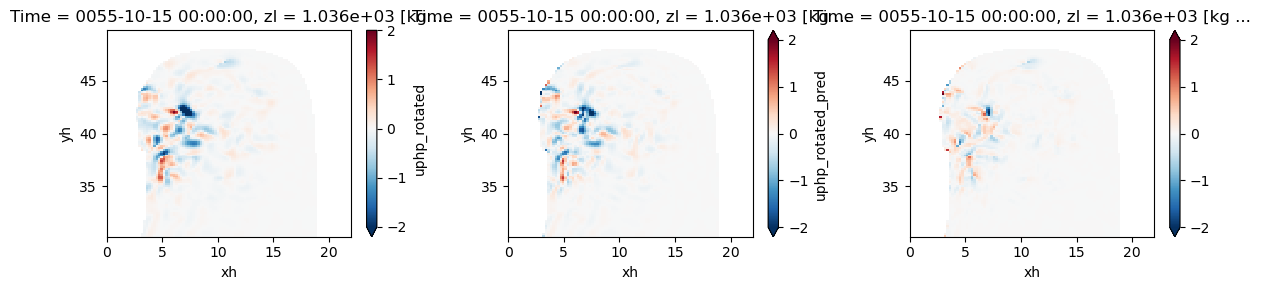

In [15]:
plt.figure(figsize=(12,3))

vmin = -2
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=0, zl=1).plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=0, zl=1).plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=0, zl=1).plot(vmin=vmin)

plt.tight_layout()

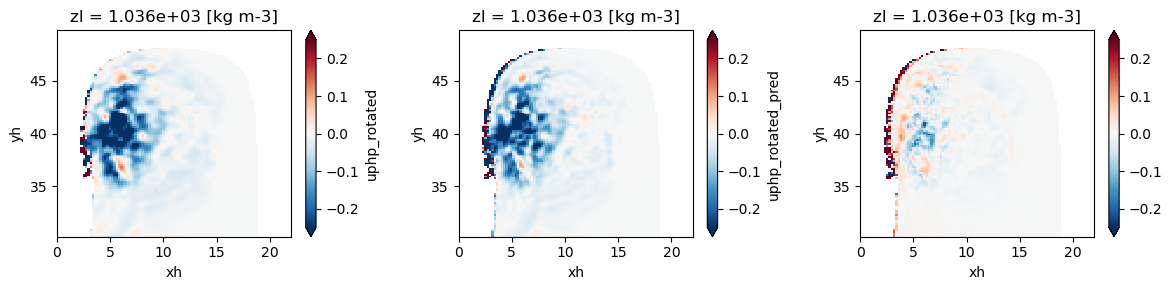

In [17]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

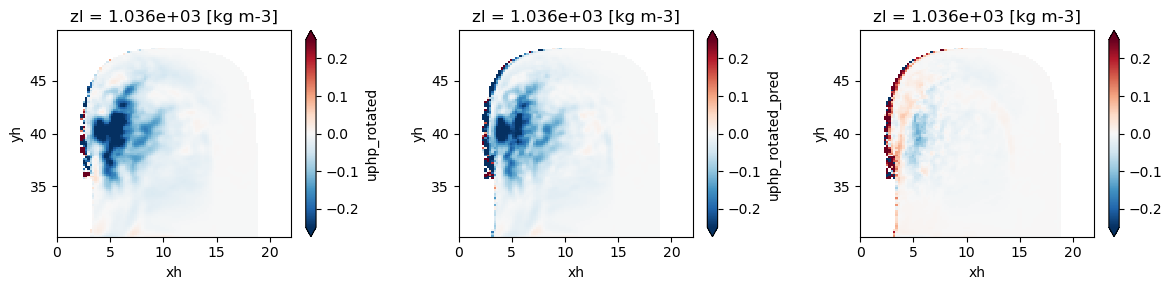

In [18]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

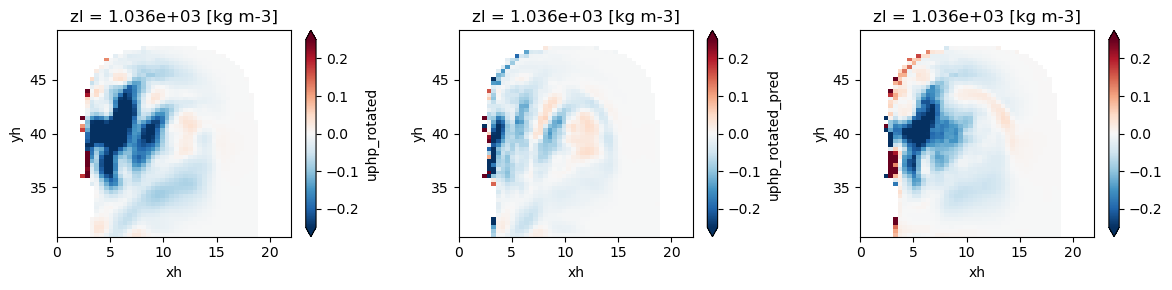

In [19]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['200']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

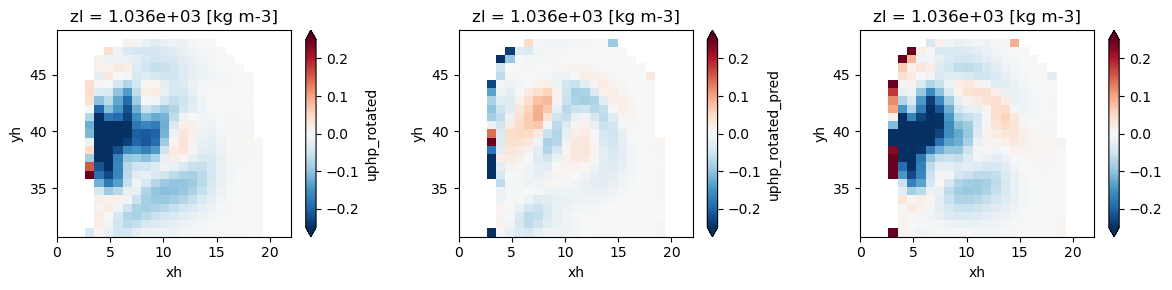

In [20]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['400']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

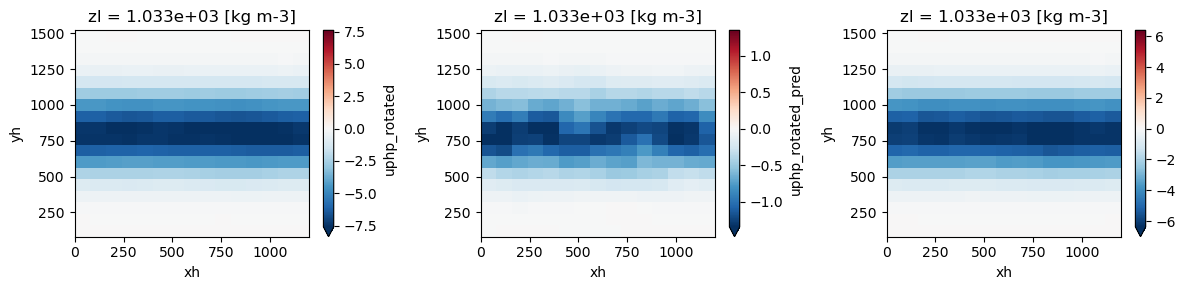

In [24]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['400']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

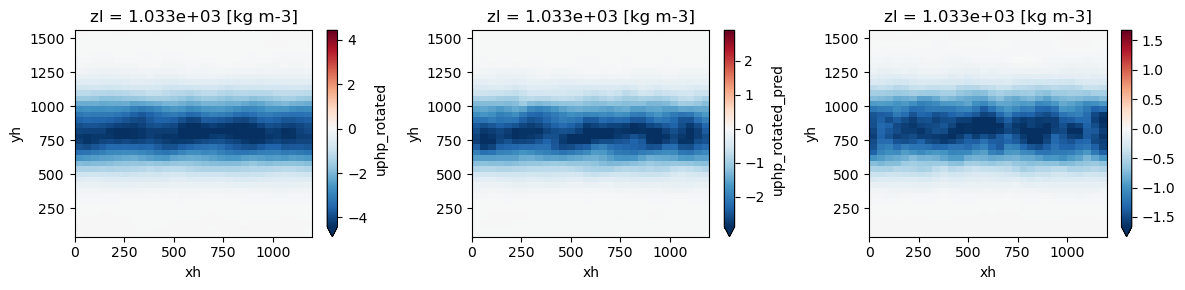

In [25]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['200']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

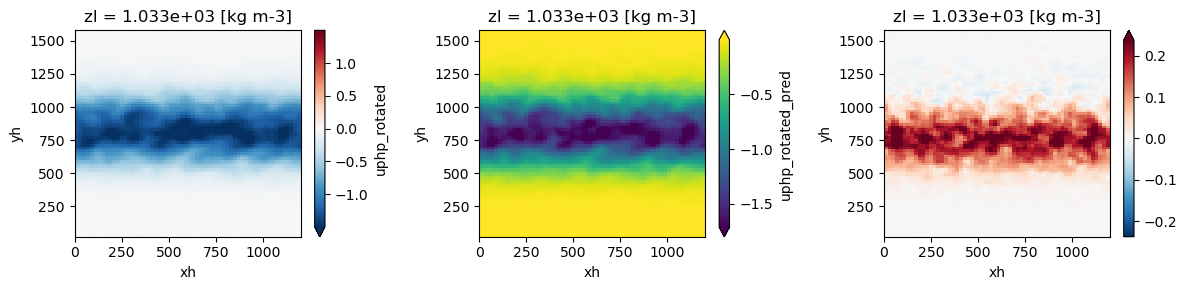

In [26]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

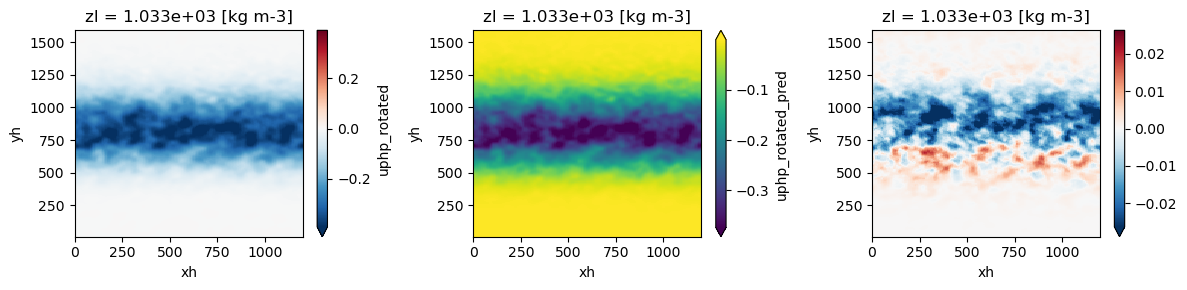

In [27]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['50']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()